In [1]:
# LangGraph
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# LangChain
from langchain.graphs import Neo4jGraph
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage

# General
import os
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from IPython.display import Image, display

In [2]:
# Get environment variables
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")
# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="gemma2-9b-it")
# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="mixtral-8x7b-32768")
graph = Neo4jGraph()
memory = MemorySaver()

In [3]:
personality_scientist_prompt = """You are an expert personality scientist. \
You will conduct a personality test using the RAISEC personality model \
The test will be a real-time conversational flow where you ask one question and wait for the reply \
Your task is to ask questions, to uncover personality traits that are related to career tracks. \
Number your questions. \
Make your questions concise.\
You can only ask one question per message do not give one question for every trait per message.\
Ex: Do you prefer alone time or crowded places?"""

trait_extractor_prompt = """Analyze this answer: {answer}, to identify personality traits. Extract the traits and return them as a string of keywords separated by commas in the format "trait1, trait2, trait3, ...". Ensure the output is strictly in the specified format and don't add any explanation to your output.
Person answer: 'I like to go with the flow and see what happens'
Correct Output Format: "spontaneous, flexible, adaptable"
Wrong output format: Final Answer: The final answer is "spontaneous, flexible, adaptable". I hope it is correct.
Reminder: do not explain or add anything other than the string of keywords.
"spontaneous, flexible, adaptable"
"""

In [4]:
class AgentState(TypedDict):
  user_message: HumanMessage
  messages: Annotated[list[AnyMessage], operator.add]
  ocupations: Annotated[list[str], operator.add]
  extracted_traits: Annotated[list[str], operator.add]

In [5]:
# Tells the model to ask questions
def questioner_node(state: AgentState):

  messages = state['messages']

  # Initialize the messages with the conversational prompt
  if len(messages) == 0:
    messages += [SystemMessage(content=personality_scientist_prompt)]

  # Add the new message to the previous list of messages
  if state['user_message']:
    messages += [state['user_message']]
  
  # Give the model the history of messages
  response = model.invoke(messages)
  return {'messages': [response]} # this adds the new AI_Message

# Asks the model to decide whether to adjust traits or not
def choose_path(state: AgentState):
  user_message = state['user_message']

  # Let the model decide if it wants to extract any personality traits or not.
  response = model.invoke(f"Person's message: {user_message}. If you don't find any valuable traits in it return 'no'. If you find traits that can be helpful in suggesting careers, return 'yes'. You have to return either 'yes' or 'no' without spaces or breaks, all lowercase.")
  
  if 'yes' in response.content.strip():
    return True # -> to go to trait_extractor
  else:
    return False # -> to end the flow

# Happens when the model decides to extract traits
def trait_extractor_node(state: AgentState):

  # Give the user's answer to the model to extract traits from it
  message = [SystemMessage(content=trait_extractor_prompt.format(answer=state['user_message']))]
  response = model.invoke(message)

  print("\n-- extracted_traits adjusted --\n")
  return {'extracted_traits': [response.content]}

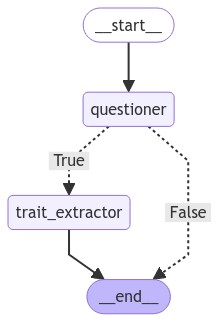

In [6]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('questioner', questioner_node)
graph_builder.add_node('trait_extractor', trait_extractor_node)

graph_builder.set_entry_point('questioner')
graph_builder.add_conditional_edges('questioner', choose_path, {True: 'trait_extractor', False: END})

graph_builder.set_finish_point('trait_extractor')

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
thread = {'configurable': {'thread_id': "1"}}


for message in graph.stream({"user_message": HumanMessage(content="When faced with a problem, I usually come up with a lot of creative solutions")}, thread, stream_mode='values'):
  if len(message['messages']) > 0:
    print(message['messages'][-1].content)

Here's my next question:

4. When faced with a problem, do you usually come up with a lot of creative solutions or focus on finding the most practical and efficient one?
Thank you for answering the questions. Based on your responses, here's a brief summary of your personality traits related to career tracks:

You tend to be a detail-oriented planner (R), a logical and analytical decision-maker (I), a reflective and observant team player (S), and a creative problem-solver (E). These traits are commonly found in careers such as research and development, data analysis, science, and design.

Keep in mind that this is a brief assessment, and your personality is more complex than can be captured in just four questions. However, this should give you a general idea of your strengths and preferences.

If you have any questions or would like more information, feel free to ask!

-- extracted_traits adjusted --

Thank you for answering the questions. Based on your responses, here's a brief summary

In [15]:
print(graph.get_state(thread).values['messages'][-1].content)

Thank you for answering the questions. Based on your responses, here's a brief summary of your personality traits related to career tracks:

You tend to be a detail-oriented planner (R), a logical and analytical decision-maker (I), a reflective and observant team player (S), and a creative problem-solver (E). These traits are commonly found in careers such as research and development, data analysis, science, and design.

Keep in mind that this is a brief assessment, and your personality is more complex than can be captured in just four questions. However, this should give you a general idea of your strengths and preferences.

If you have any questions or would like more information, feel free to ask!


In [23]:
traits = graph.get_state(thread).values['extracted_traits']

['organized, detail-oriented, time-conscious, controlling',
 'rational, analytical, logical',
 'observant, introspective, reserved, cautious',
 'creative, resourceful, optimistic']

In [22]:
adjusted_traits = []
[adjusted_traits.append(trait) for trait in traits]

for trait in traits:
  for sep_trait in trait.split(","):
    adjusted_traits.append(sep_trait)

adjusted_traits

['organized, detail-oriented, time-conscious, controlling',
 'rational, analytical, logical',
 'observant, introspective, reserved, cautious',
 'creative, resourceful, optimistic',
 'organized',
 ' detail-oriented',
 ' time-conscious',
 ' controlling',
 'rational',
 ' analytical',
 ' logical',
 'observant',
 ' introspective',
 ' reserved',
 ' cautious',
 'creative',
 ' resourceful',
 ' optimistic']